In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_075_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:19 - loss: 0.3409 - STD: 1.6881e-04 - MAE: 0.5753

 4/64 [>.............................] - ETA: 1s - loss: 0.1306 - STD: 3.6142e-04 - MAE: 0.2945  

 5/64 [=>............................] - ETA: 2s - loss: 0.1070 - STD: 3.1926e-04 - MAE: 0.2517

 6/64 [=>............................] - ETA: 7s - loss: 0.1047 - STD: 2.7882e-04 - MAE: 0.2270

10/64 [===>..........................] - ETA: 4s - loss: 0.0707 - STD: 1.7576e-04 - MAE: 0.1892

11/64 [====>.........................] - ETA: 4s - loss: 0.0668 - STD: 1.6010e-04 - MAE: 0.1853

12/64 [====>.........................] - ETA: 4s - loss: 0.0636 - STD: 1.4698e-04 - MAE: 0.1821

13/64 [=====>........................] - ETA: 4s - loss: 0.0610 - STD: 1.3597e-04 - MAE: 0.1795

14/64 [=====>........................] - ETA: 3s - loss: 0.0588 - STD: 1.2664e-04 - MAE: 0.1772

15/64 [======>.......................] - ETA: 3s - loss: 0.0568 - STD: 1.1866e-04 - MAE: 0.1753

16/64 [======>.......................] - ETA: 3s - loss: 0.0552 - STD: 1.1180e-04 - MAE: 0.1737

17/64 [======>.......................] - ETA: 3s - loss: 0.0537 - STD: 1.0579e-04 - MAE: 0.1721

18/64 [=======>......................] - ETA: 3s - loss: 0.0524 - STD: 1.0046e-04 - MAE: 0.1706

19/64 [=======>......................] - ETA: 3s - loss: 0.0511 - STD: 9.5751e-05 - MAE: 0.1690

20/64 [========>.....................] - ETA: 3s - loss: 0.0500 - STD: 9.1562e-05 - MAE: 0.1676

21/64 [========>.....................] - ETA: 3s - loss: 0.0489 - STD: 8.7815e-05 - MAE: 0.1661

22/64 [=========>....................] - ETA: 3s - loss: 0.0479 - STD: 8.4437e-05 - MAE: 0.1645

23/64 [=========>....................] - ETA: 3s - loss: 0.0468 - STD: 8.1365e-05 - MAE: 0.1629

24/64 [==========>...................] - ETA: 2s - loss: 0.0459 - STD: 7.8608e-05 - MAE: 0.1612

25/64 [==========>...................] - ETA: 2s - loss: 0.0449 - STD: 7.6100e-05 - MAE: 0.1594

26/64 [===========>..................] - ETA: 2s - loss: 0.0440 - STD: 7.3782e-05 - MAE: 0.1575

27/64 [===========>..................] - ETA: 2s - loss: 0.0430 - STD: 7.1651e-05 - MAE: 0.1556

28/64 [============>.................] - ETA: 2s - loss: 0.0421 - STD: 6.9654e-05 - MAE: 0.1535

29/64 [============>.................] - ETA: 2s - loss: 0.0411 - STD: 6.7836e-05 - MAE: 0.1513

30/64 [=============>................] - ETA: 2s - loss: 0.0402 - STD: 6.6143e-05 - MAE: 0.1491

31/64 [=============>................] - ETA: 2s - loss: 0.0393 - STD: 6.4498e-05 - MAE: 0.1468

32/64 [==============>...............] - ETA: 2s - loss: 0.0384 - STD: 6.3006e-05 - MAE: 0.1446

33/64 [==============>...............] - ETA: 2s - loss: 0.0375 - STD: 6.1588e-05 - MAE: 0.1425

34/64 [==============>...............] - ETA: 2s - loss: 0.0366 - STD: 6.0290e-05 - MAE: 0.1406

35/64 [===============>..............] - ETA: 2s - loss: 0.0359 - STD: 5.9021e-05 - MAE: 0.1388

36/64 [===============>..............] - ETA: 1s - loss: 0.0351 - STD: 5.7925e-05 - MAE: 0.1373

37/64 [================>.............] - ETA: 1s - loss: 0.0345 - STD: 5.6813e-05 - MAE: 0.1360

38/64 [================>.............] - ETA: 1s - loss: 0.0339 - STD: 5.5694e-05 - MAE: 0.1348

39/64 [=================>............] - ETA: 1s - loss: 0.0333 - STD: 5.4615e-05 - MAE: 0.1338

40/64 [=================>............] - ETA: 1s - loss: 0.0328 - STD: 5.3642e-05 - MAE: 0.1329

41/64 [==================>...........] - ETA: 1s - loss: 0.0323 - STD: 5.2736e-05 - MAE: 0.1319

42/64 [==================>...........] - ETA: 1s - loss: 0.0318 - STD: 5.1783e-05 - MAE: 0.1310

43/64 [===================>..........] - ETA: 1s - loss: 0.0313 - STD: 5.0830e-05 - MAE: 0.1301

44/64 [===================>..........] - ETA: 1s - loss: 0.0308 - STD: 4.9935e-05 - MAE: 0.1291

45/64 [====================>.........] - ETA: 1s - loss: 0.0304 - STD: 4.9059e-05 - MAE: 0.1281

46/64 [====================>.........] - ETA: 1s - loss: 0.0299 - STD: 4.8203e-05 - MAE: 0.1271

47/64 [=====================>........] - ETA: 1s - loss: 0.0295 - STD: 4.7351e-05 - MAE: 0.1261

48/64 [=====================>........] - ETA: 1s - loss: 0.0291 - STD: 4.6550e-05 - MAE: 0.1251

49/64 [=====================>........] - ETA: 1s - loss: 0.0287 - STD: 4.5753e-05 - MAE: 0.1241

50/64 [======================>.......] - ETA: 0s - loss: 0.0283 - STD: 4.4956e-05 - MAE: 0.1232

51/64 [======================>.......] - ETA: 0s - loss: 0.0279 - STD: 4.4213e-05 - MAE: 0.1222

52/64 [=======================>......] - ETA: 0s - loss: 0.0276 - STD: 4.3454e-05 - MAE: 0.1213

53/64 [=======================>......] - ETA: 0s - loss: 0.0273 - STD: 4.2748e-05 - MAE: 0.1205

54/64 [========================>.....] - ETA: 0s - loss: 0.0270 - STD: 4.2063e-05 - MAE: 0.1197

55/64 [========================>.....] - ETA: 0s - loss: 0.0267 - STD: 4.1396e-05 - MAE: 0.1189

56/64 [=========================>....] - ETA: 0s - loss: 0.0264 - STD: 4.0723e-05 - MAE: 0.1181

57/64 [=========================>....] - ETA: 0s - loss: 0.0261 - STD: 4.0091e-05 - MAE: 0.1174

58/64 [==========================>...] - ETA: 0s - loss: 0.0258 - STD: 3.9519e-05 - MAE: 0.1167

59/64 [==========================>...] - ETA: 0s - loss: 0.0255 - STD: 3.8945e-05 - MAE: 0.1160

60/64 [===========================>..] - ETA: 0s - loss: 0.0253 - STD: 3.8395e-05 - MAE: 0.1153

61/64 [===========================>..] - ETA: 0s - loss: 0.0250 - STD: 3.7854e-05 - MAE: 0.1146

62/64 [============================>.] - ETA: 0s - loss: 0.0248 - STD: 3.7370e-05 - MAE: 0.1140

63/64 [============================>.] - ETA: 0s - loss: 0.0245 - STD: 3.6875e-05 - MAE: 0.1135

64/64 [==============================] - ETA: 0s - loss: 0.0243 - STD: 3.6376e-05 - MAE: 0.1129

64/64 [==============================] - 6s 80ms/step - loss: 0.0243 - STD: 3.6376e-05 - MAE: 0.1129 - val_loss: 0.0095 - val_STD: 5.6440e-06 - val_MAE: 0.0775


Epoch 2/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0099 - STD: 6.5647e-06 - MAE: 0.0786

 2/64 [..............................] - ETA: 4s - loss: 0.0100 - STD: 6.1523e-06 - MAE: 0.0794

 3/64 [>.............................] - ETA: 4s - loss: 0.0100 - STD: 6.5854e-06 - MAE: 0.0796

 4/64 [>.............................] - ETA: 4s - loss: 0.0100 - STD: 6.0442e-06 - MAE: 0.0799

 5/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 5.9148e-06 - MAE: 0.0799

 6/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 6.0452e-06 - MAE: 0.0800

 7/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 6.5053e-06 - MAE: 0.0798

 8/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 6.4033e-06 - MAE: 0.0798

 9/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 6.4318e-06 - MAE: 0.0798

10/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 6.4978e-06 - MAE: 0.0797

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 6.2709e-06 - MAE: 0.0795

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 6.2591e-06 - MAE: 0.0794

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 6.2940e-06 - MAE: 0.0792

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 6.1632e-06 - MAE: 0.0792

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 6.2756e-06 - MAE: 0.0790

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 6.2436e-06 - MAE: 0.0789

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 6.1743e-06 - MAE: 0.0788

18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 6.1271e-06 - MAE: 0.0787

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 6.0470e-06 - MAE: 0.0786

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 6.0045e-06 - MAE: 0.0786

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 6.0723e-06 - MAE: 0.0784

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 6.1151e-06 - MAE: 0.0783

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 6.1829e-06 - MAE: 0.0783

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 6.1135e-06 - MAE: 0.0782

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.0731e-06 - MAE: 0.0782

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.0291e-06 - MAE: 0.0782

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 5.9803e-06 - MAE: 0.0782

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 5.9275e-06 - MAE: 0.0782

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 5.9015e-06 - MAE: 0.0782

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 5.8782e-06 - MAE: 0.0782

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 5.8809e-06 - MAE: 0.0782

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 5.8875e-06 - MAE: 0.0782

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 5.8821e-06 - MAE: 0.0782

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 5.8434e-06 - MAE: 0.0782

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 5.8341e-06 - MAE: 0.0782

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 5.7888e-06 - MAE: 0.0782

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 5.7507e-06 - MAE: 0.0782

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 5.7272e-06 - MAE: 0.0782

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 5.7075e-06 - MAE: 0.0782

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 5.7147e-06 - MAE: 0.0782

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 5.6737e-06 - MAE: 0.0782

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 5.6225e-06 - MAE: 0.0782

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 5.5830e-06 - MAE: 0.0782

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.5513e-06 - MAE: 0.0782

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.5189e-06 - MAE: 0.0782

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 5.4839e-06 - MAE: 0.0781

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 5.4741e-06 - MAE: 0.0781

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 5.4691e-06 - MAE: 0.0781

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 5.4597e-06 - MAE: 0.0781

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 5.4425e-06 - MAE: 0.0781

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.4377e-06 - MAE: 0.0781

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.4165e-06 - MAE: 0.0781

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.3865e-06 - MAE: 0.0781

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.3789e-06 - MAE: 0.0781

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 5.3798e-06 - MAE: 0.0781

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 5.3778e-06 - MAE: 0.0781

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 5.3674e-06 - MAE: 0.0781

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 5.3627e-06 - MAE: 0.0781

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 5.3510e-06 - MAE: 0.0781

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 5.3539e-06 - MAE: 0.0781

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 5.3478e-06 - MAE: 0.0781

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 5.3380e-06 - MAE: 0.0781

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 5.3242e-06 - MAE: 0.0781

64/64 [==============================] - 4s 68ms/step - loss: 0.0099 - STD: 5.3242e-06 - MAE: 0.0781 - val_loss: 0.0094 - val_STD: 4.1145e-06 - val_MAE: 0.0763


Epoch 3/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0103 - STD: 4.5390e-06 - MAE: 0.0792

 2/64 [..............................] - ETA: 4s - loss: 0.0103 - STD: 4.5434e-06 - MAE: 0.0789

 3/64 [>.............................] - ETA: 4s - loss: 0.0102 - STD: 4.5397e-06 - MAE: 0.0785

 4/64 [>.............................] - ETA: 4s - loss: 0.0100 - STD: 4.6722e-06 - MAE: 0.0783

 5/64 [=>............................] - ETA: 4s - loss: 0.0101 - STD: 4.8190e-06 - MAE: 0.0784

 6/64 [=>............................] - ETA: 3s - loss: 0.0101 - STD: 4.9109e-06 - MAE: 0.0784

 7/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 5.0281e-06 - MAE: 0.0784

 8/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 5.2808e-06 - MAE: 0.0784

 9/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 5.2847e-06 - MAE: 0.0783

10/64 [===>..........................] - ETA: 3s - loss: 0.0100 - STD: 5.3210e-06 - MAE: 0.0783

11/64 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 5.4414e-06 - MAE: 0.0783

12/64 [====>.........................] - ETA: 3s - loss: 0.0100 - STD: 5.5632e-06 - MAE: 0.0783

13/64 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 5.6162e-06 - MAE: 0.0783

14/64 [=====>........................] - ETA: 3s - loss: 0.0100 - STD: 5.6391e-06 - MAE: 0.0784

15/64 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 5.6811e-06 - MAE: 0.0783

16/64 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 5.6724e-06 - MAE: 0.0783

17/64 [======>.......................] - ETA: 3s - loss: 0.0100 - STD: 5.6807e-06 - MAE: 0.0782

18/64 [=======>......................] - ETA: 3s - loss: 0.0100 - STD: 5.6231e-06 - MAE: 0.0782

19/64 [=======>......................] - ETA: 3s - loss: 0.0100 - STD: 5.5619e-06 - MAE: 0.0782

20/64 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 5.5243e-06 - MAE: 0.0782

21/64 [========>.....................] - ETA: 2s - loss: 0.0100 - STD: 5.4974e-06 - MAE: 0.0782

22/64 [=========>....................] - ETA: 2s - loss: 0.0100 - STD: 5.4732e-06 - MAE: 0.0782

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 5.4504e-06 - MAE: 0.0781

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 5.4478e-06 - MAE: 0.0781

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 5.4685e-06 - MAE: 0.0781

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 5.4698e-06 - MAE: 0.0780

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 5.4713e-06 - MAE: 0.0781

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 5.5099e-06 - MAE: 0.0780

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 5.5357e-06 - MAE: 0.0780

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 5.5466e-06 - MAE: 0.0779

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 5.5530e-06 - MAE: 0.0780

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 5.5600e-06 - MAE: 0.0780

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 5.5557e-06 - MAE: 0.0779

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 5.5472e-06 - MAE: 0.0779

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 5.5450e-06 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 5.5527e-06 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 5.5772e-06 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 5.5661e-06 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 5.5496e-06 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 5.5796e-06 - MAE: 0.0779

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 5.5853e-06 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 5.5817e-06 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 5.5695e-06 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 5.5510e-06 - MAE: 0.0778

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.5414e-06 - MAE: 0.0778

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.5379e-06 - MAE: 0.0778

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 5.5199e-06 - MAE: 0.0778

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 5.5204e-06 - MAE: 0.0778

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 5.5234e-06 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 5.5482e-06 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 5.5735e-06 - MAE: 0.0778

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.5800e-06 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.5869e-06 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 5.5795e-06 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 5.5850e-06 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 5.5848e-06 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 5.5866e-06 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 5.5855e-06 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 5.5818e-06 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 5.5960e-06 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 5.6128e-06 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 5.6420e-06 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 5.6757e-06 - MAE: 0.0779

64/64 [==============================] - 4s 68ms/step - loss: 0.0099 - STD: 5.6757e-06 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 6.7226e-06 - val_MAE: 0.0764


Epoch 4/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0099 - STD: 7.7107e-06 - MAE: 0.0777

 2/64 [..............................] - ETA: 4s - loss: 0.0098 - STD: 7.7487e-06 - MAE: 0.0778

 3/64 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 7.8108e-06 - MAE: 0.0776

 4/64 [>.............................] - ETA: 4s - loss: 0.0099 - STD: 7.8405e-06 - MAE: 0.0777

 5/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 7.8874e-06 - MAE: 0.0780

 6/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 7.9419e-06 - MAE: 0.0780

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 7.9766e-06 - MAE: 0.0780

 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 7.9960e-06 - MAE: 0.0780

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 7.9944e-06 - MAE: 0.0779

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 7.9951e-06 - MAE: 0.0779

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 7.8844e-06 - MAE: 0.0779

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 7.7312e-06 - MAE: 0.0779

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 7.5744e-06 - MAE: 0.0780

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 7.4390e-06 - MAE: 0.0779

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 7.2606e-06 - MAE: 0.0779

17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 7.2393e-06 - MAE: 0.0780

18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 7.2334e-06 - MAE: 0.0780

19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 7.2151e-06 - MAE: 0.0780

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 7.2119e-06 - MAE: 0.0780

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 7.2199e-06 - MAE: 0.0780

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 7.2275e-06 - MAE: 0.0780

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 7.2429e-06 - MAE: 0.0780

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 7.2940e-06 - MAE: 0.0780

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 7.3469e-06 - MAE: 0.0780

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 7.4134e-06 - MAE: 0.0780

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 7.4762e-06 - MAE: 0.0779

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 7.5386e-06 - MAE: 0.0779

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 7.5968e-06 - MAE: 0.0779

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 7.6763e-06 - MAE: 0.0779

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 7.7442e-06 - MAE: 0.0778

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 7.8010e-06 - MAE: 0.0779

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 7.8586e-06 - MAE: 0.0779

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 7.9173e-06 - MAE: 0.0779

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 7.9727e-06 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 8.0323e-06 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 8.0843e-06 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 8.1239e-06 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 8.1672e-06 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 8.2141e-06 - MAE: 0.0779

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 8.2586e-06 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 8.2989e-06 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 8.3418e-06 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 8.3912e-06 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 8.4327e-06 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 8.4756e-06 - MAE: 0.0779

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 8.5150e-06 - MAE: 0.0779

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 8.5651e-06 - MAE: 0.0779

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 8.6015e-06 - MAE: 0.0779

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 8.6136e-06 - MAE: 0.0779

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 8.6133e-06 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 8.6218e-06 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 8.6306e-06 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 8.6396e-06 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 8.6564e-06 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 8.6585e-06 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 8.6693e-06 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 8.7120e-06 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 8.7561e-06 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 8.7995e-06 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 8.8430e-06 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 8.8802e-06 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 8.9142e-06 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 8.9375e-06 - MAE: 0.0779

64/64 [==============================] - 4s 68ms/step - loss: 0.0099 - STD: 8.9375e-06 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 7.4822e-06 - val_MAE: 0.0764


Epoch 5/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0098 - STD: 9.2049e-06 - MAE: 0.0780

 2/64 [..............................] - ETA: 4s - loss: 0.0099 - STD: 9.2887e-06 - MAE: 0.0781

 3/64 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 9.7661e-06 - MAE: 0.0778

 4/64 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 1.0196e-05 - MAE: 0.0776

 5/64 [=>............................] - ETA: 4s - loss: 0.0098 - STD: 1.0432e-05 - MAE: 0.0778

 6/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 1.0602e-05 - MAE: 0.0778

 7/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 1.0761e-05 - MAE: 0.0777

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 1.0840e-05 - MAE: 0.0778

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 1.0880e-05 - MAE: 0.0778

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.0903e-05 - MAE: 0.0778

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.0956e-05 - MAE: 0.0778

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.1020e-05 - MAE: 0.0779

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.1095e-05 - MAE: 0.0779

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 1.1183e-05 - MAE: 0.0779

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.1258e-05 - MAE: 0.0779

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.1334e-05 - MAE: 0.0779

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 1.1390e-05 - MAE: 0.0778

18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 1.1461e-05 - MAE: 0.0778

19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 1.1537e-05 - MAE: 0.0779

20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.1624e-05 - MAE: 0.0779

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.1693e-05 - MAE: 0.0779

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 1.1806e-05 - MAE: 0.0779

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 1.1911e-05 - MAE: 0.0779

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 1.2011e-05 - MAE: 0.0780

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 1.2104e-05 - MAE: 0.0780

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.2233e-05 - MAE: 0.0780

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 1.2351e-05 - MAE: 0.0779

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.2462e-05 - MAE: 0.0779

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 1.2590e-05 - MAE: 0.0779

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.2714e-05 - MAE: 0.0779

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 1.2810e-05 - MAE: 0.0779

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.2907e-05 - MAE: 0.0779

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 1.3004e-05 - MAE: 0.0779

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.3081e-05 - MAE: 0.0779

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.3147e-05 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.3252e-05 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.3373e-05 - MAE: 0.0779

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 1.3490e-05 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.3604e-05 - MAE: 0.0779

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 1.3736e-05 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 1.4039e-05 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.4196e-05 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 1.4359e-05 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.4528e-05 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 1.4709e-05 - MAE: 0.0780

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.4890e-05 - MAE: 0.0780

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 1.5063e-05 - MAE: 0.0780

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.5239e-05 - MAE: 0.0780

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.5421e-05 - MAE: 0.0780

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.5603e-05 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.5784e-05 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.5981e-05 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.6180e-05 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.6396e-05 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.6624e-05 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.6835e-05 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.7003e-05 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.7172e-05 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.7341e-05 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.7505e-05 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.7681e-05 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.7863e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.8071e-05 - MAE: 0.0779

64/64 [==============================] - 4s 68ms/step - loss: 0.0099 - STD: 1.8071e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 2.2783e-05 - val_MAE: 0.0764


Epoch 6/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0101 - STD: 3.1228e-05 - MAE: 0.0791

 2/64 [..............................] - ETA: 4s - loss: 0.0100 - STD: 3.1376e-05 - MAE: 0.0784

 3/64 [>.............................] - ETA: 4s - loss: 0.0101 - STD: 3.1619e-05 - MAE: 0.0785

 4/64 [>.............................] - ETA: 4s - loss: 0.0100 - STD: 3.2045e-05 - MAE: 0.0782

 5/64 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 3.2499e-05 - MAE: 0.0780

 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 3.2675e-05 - MAE: 0.0779

 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 3.2865e-05 - MAE: 0.0780

 8/64 [==>...........................] - ETA: 3s - loss: 0.0100 - STD: 3.3073e-05 - MAE: 0.0781

 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 3.3273e-05 - MAE: 0.0780

10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 3.3488e-05 - MAE: 0.0780

11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 3.3817e-05 - MAE: 0.0779

12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 3.4239e-05 - MAE: 0.0779

13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 3.4728e-05 - MAE: 0.0778

14/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 3.5175e-05 - MAE: 0.0779

15/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 3.5695e-05 - MAE: 0.0779

16/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 3.6079e-05 - MAE: 0.0779

17/64 [======>.......................] - ETA: 3s - loss: 0.0099 - STD: 3.6464e-05 - MAE: 0.0779

18/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 3.6841e-05 - MAE: 0.0779

19/64 [=======>......................] - ETA: 3s - loss: 0.0099 - STD: 3.7275e-05 - MAE: 0.0780

20/64 [========>.....................] - ETA: 3s - loss: 0.0099 - STD: 3.7692e-05 - MAE: 0.0780

21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 3.8092e-05 - MAE: 0.0780

22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 3.8532e-05 - MAE: 0.0780

23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 3.8971e-05 - MAE: 0.0780

24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 3.9432e-05 - MAE: 0.0780

25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 3.9898e-05 - MAE: 0.0780

26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 4.0436e-05 - MAE: 0.0780

27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 4.0958e-05 - MAE: 0.0779

28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 4.1510e-05 - MAE: 0.0779

29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 4.2087e-05 - MAE: 0.0779

30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 4.2688e-05 - MAE: 0.0778

31/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 4.3327e-05 - MAE: 0.0779

32/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 4.3950e-05 - MAE: 0.0779

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 4.4601e-05 - MAE: 0.0779

34/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 4.5275e-05 - MAE: 0.0779

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 4.5910e-05 - MAE: 0.0779

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 4.6587e-05 - MAE: 0.0779

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 4.7250e-05 - MAE: 0.0779

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 4.8613e-05 - MAE: 0.0780

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 4.9302e-05 - MAE: 0.0780

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 5.0024e-05 - MAE: 0.0779

42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 5.0753e-05 - MAE: 0.0779

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 5.1495e-05 - MAE: 0.0779

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 5.2256e-05 - MAE: 0.0779

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.3036e-05 - MAE: 0.0779

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 5.3826e-05 - MAE: 0.0779

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 5.4642e-05 - MAE: 0.0779

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 5.5472e-05 - MAE: 0.0779

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 5.6356e-05 - MAE: 0.0779

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 5.7273e-05 - MAE: 0.0779

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 5.8202e-05 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 5.9135e-05 - MAE: 0.0779

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 6.0057e-05 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 6.1009e-05 - MAE: 0.0779

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 6.1986e-05 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 6.2956e-05 - MAE: 0.0779

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 6.3965e-05 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 6.5010e-05 - MAE: 0.0779

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 6.6060e-05 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 6.7155e-05 - MAE: 0.0779

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 6.8285e-05 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 6.9428e-05 - MAE: 0.0779

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 7.0611e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 7.1843e-05 - MAE: 0.0779

64/64 [==============================] - 4s 70ms/step - loss: 0.0099 - STD: 7.1843e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 1.1003e-04 - val_MAE: 0.0762


Epoch 7/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0098 - STD: 1.5341e-04 - MAE: 0.0775

 2/64 [..............................] - ETA: 4s - loss: 0.0098 - STD: 1.5543e-04 - MAE: 0.0774

 3/64 [>.............................] - ETA: 4s - loss: 0.0098 - STD: 1.5772e-04 - MAE: 0.0772

 4/64 [>.............................] - ETA: 4s - loss: 0.0097 - STD: 1.5999e-04 - MAE: 0.0773

 5/64 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 1.6267e-04 - MAE: 0.0773

 6/64 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 1.6505e-04 - MAE: 0.0772

 7/64 [==>...........................] - ETA: 3s - loss: 0.0097 - STD: 1.6767e-04 - MAE: 0.0773

 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 1.7033e-04 - MAE: 0.0774

 9/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 1.7295e-04 - MAE: 0.0775

10/64 [===>..........................] - ETA: 3s - loss: 0.0098 - STD: 1.7562e-04 - MAE: 0.0776

11/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 1.7819e-04 - MAE: 0.0776

12/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 1.8115e-04 - MAE: 0.0776

13/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 1.8397e-04 - MAE: 0.0776

14/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 1.8711e-04 - MAE: 0.0776

15/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 1.9041e-04 - MAE: 0.0776

16/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 1.9370e-04 - MAE: 0.0776

17/64 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 1.9705e-04 - MAE: 0.0777

18/64 [=======>......................] - ETA: 3s - loss: 0.0098 - STD: 2.0043e-04 - MAE: 0.0776

19/64 [=======>......................] - ETA: 2s - loss: 0.0098 - STD: 2.0392e-04 - MAE: 0.0777

20/64 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 2.0763e-04 - MAE: 0.0777

21/64 [========>.....................] - ETA: 2s - loss: 0.0098 - STD: 2.1145e-04 - MAE: 0.0776

22/64 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 2.1537e-04 - MAE: 0.0777

23/64 [=========>....................] - ETA: 2s - loss: 0.0098 - STD: 2.1945e-04 - MAE: 0.0777

24/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 2.2353e-04 - MAE: 0.0776

25/64 [==========>...................] - ETA: 2s - loss: 0.0098 - STD: 2.2769e-04 - MAE: 0.0777

26/64 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 2.3208e-04 - MAE: 0.0777

27/64 [===========>..................] - ETA: 2s - loss: 0.0098 - STD: 2.3651e-04 - MAE: 0.0777

28/64 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 2.4109e-04 - MAE: 0.0777

29/64 [============>.................] - ETA: 2s - loss: 0.0098 - STD: 2.4575e-04 - MAE: 0.0777

30/64 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 2.5052e-04 - MAE: 0.0777

31/64 [=============>................] - ETA: 2s - loss: 0.0098 - STD: 2.5559e-04 - MAE: 0.0777

32/64 [==============>...............] - ETA: 2s - loss: 0.0098 - STD: 2.6073e-04 - MAE: 0.0777

33/64 [==============>...............] - ETA: 2s - loss: 0.0099 - STD: 2.6606e-04 - MAE: 0.0777

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.7163e-04 - MAE: 0.0777

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.7733e-04 - MAE: 0.0777

36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.8308e-04 - MAE: 0.0778

37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.8897e-04 - MAE: 0.0778

38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.9512e-04 - MAE: 0.0778

39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 3.0151e-04 - MAE: 0.0778

40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 3.0804e-04 - MAE: 0.0777

41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 3.1471e-04 - MAE: 0.0778

43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.2846e-04 - MAE: 0.0777

44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.3569e-04 - MAE: 0.0777

45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.4318e-04 - MAE: 0.0777

46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.5091e-04 - MAE: 0.0777

47/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 3.5898e-04 - MAE: 0.0777

48/64 [=====================>........] - ETA: 1s - loss: 0.0099 - STD: 3.6727e-04 - MAE: 0.0777

49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 3.7571e-04 - MAE: 0.0777

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 3.8430e-04 - MAE: 0.0777

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 3.9325e-04 - MAE: 0.0777

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 4.0255e-04 - MAE: 0.0777

53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 4.1221e-04 - MAE: 0.0777

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 4.2204e-04 - MAE: 0.0777

55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 4.3221e-04 - MAE: 0.0777

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 4.4277e-04 - MAE: 0.0777

57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 4.5366e-04 - MAE: 0.0777

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 4.6491e-04 - MAE: 0.0777

59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 4.7667e-04 - MAE: 0.0777

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 4.8869e-04 - MAE: 0.0777

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 5.0104e-04 - MAE: 0.0777

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 5.1376e-04 - MAE: 0.0777

63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 5.2693e-04 - MAE: 0.0777

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 5.4022e-04 - MAE: 0.0777

64/64 [==============================] - 4s 69ms/step - loss: 0.0099 - STD: 5.4022e-04 - MAE: 0.0777 - val_loss: 0.0093 - val_STD: 9.9640e-04 - val_MAE: 0.0759


Epoch 8/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0095 - STD: 0.0014 - MAE: 0.0771

 2/64 [..............................] - ETA: 3s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0777

 3/64 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 0.0015 - MAE: 0.0773

 4/64 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 0.0015 - MAE: 0.0773

 5/64 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 0.0016 - MAE: 0.0773

 6/64 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 0.0016 - MAE: 0.0774

 7/64 [==>...........................] - ETA: 3s - loss: 0.0097 - STD: 0.0016 - MAE: 0.0774

 8/64 [==>...........................] - ETA: 3s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0773

 9/64 [===>..........................] - ETA: 3s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0773

10/64 [===>..........................] - ETA: 3s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0773

11/64 [====>.........................] - ETA: 3s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0773

12/64 [====>.........................] - ETA: 3s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0773

13/64 [=====>........................] - ETA: 3s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0773

14/64 [=====>........................] - ETA: 3s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0774

15/64 [======>.......................] - ETA: 3s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0773

16/64 [======>.......................] - ETA: 3s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0773

17/64 [======>.......................] - ETA: 3s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0773

18/64 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.0021 - MAE: 0.0773

19/64 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.0021 - MAE: 0.0773

20/64 [========>.....................] - ETA: 2s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0772

22/64 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0772

23/64 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0771

24/64 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.0024 - MAE: 0.0772

25/64 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.0024 - MAE: 0.0771

26/64 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0771

27/64 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0771

28/64 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0771

29/64 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.0027 - MAE: 0.0771

30/64 [=============>................] - ETA: 2s - loss: 0.0097 - STD: 0.0027 - MAE: 0.0772

31/64 [=============>................] - ETA: 2s - loss: 0.0097 - STD: 0.0028 - MAE: 0.0772

32/64 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0029 - MAE: 0.0772

33/64 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0030 - MAE: 0.0771

34/64 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0030 - MAE: 0.0771

35/64 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.0031 - MAE: 0.0771

36/64 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.0032 - MAE: 0.0770

37/64 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0033 - MAE: 0.0770

38/64 [================>.............] - ETA: 1s - loss: 0.0096 - STD: 0.0033 - MAE: 0.0770

39/64 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0034 - MAE: 0.0770

40/64 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0035 - MAE: 0.0770

41/64 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0036 - MAE: 0.0769

42/64 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0037 - MAE: 0.0769

43/64 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 0.0038 - MAE: 0.0768

44/64 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 0.0039 - MAE: 0.0768

45/64 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.0040 - MAE: 0.0767

46/64 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.0041 - MAE: 0.0767

47/64 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.0042 - MAE: 0.0767

48/64 [=====================>........] - ETA: 1s - loss: 0.0095 - STD: 0.0044 - MAE: 0.0766

49/64 [=====================>........] - ETA: 0s - loss: 0.0095 - STD: 0.0045 - MAE: 0.0766

50/64 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 0.0046 - MAE: 0.0766

51/64 [======================>.......] - ETA: 0s - loss: 0.0095 - STD: 0.0047 - MAE: 0.0765

52/64 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.0049 - MAE: 0.0765

53/64 [=======================>......] - ETA: 0s - loss: 0.0095 - STD: 0.0050 - MAE: 0.0765

54/64 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0051 - MAE: 0.0764

55/64 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0053 - MAE: 0.0764

56/64 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0054 - MAE: 0.0763

57/64 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0056 - MAE: 0.0763

58/64 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 0.0058 - MAE: 0.0762

59/64 [==========================>...] - ETA: 0s - loss: 0.0094 - STD: 0.0059 - MAE: 0.0762

60/64 [===========================>..] - ETA: 0s - loss: 0.0094 - STD: 0.0061 - MAE: 0.0761

61/64 [===========================>..] - ETA: 0s - loss: 0.0094 - STD: 0.0063 - MAE: 0.0761

62/64 [============================>.] - ETA: 0s - loss: 0.0094 - STD: 0.0064 - MAE: 0.0760

63/64 [============================>.] - ETA: 0s - loss: 0.0094 - STD: 0.0066 - MAE: 0.0760

64/64 [==============================] - ETA: 0s - loss: 0.0094 - STD: 0.0068 - MAE: 0.0759

64/64 [==============================] - 4s 67ms/step - loss: 0.0094 - STD: 0.0068 - MAE: 0.0759 - val_loss: 0.0080 - val_STD: 0.0129 - val_MAE: 0.0710


Epoch 9/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0085 - STD: 0.0193 - MAE: 0.0722

 2/64 [..............................] - ETA: 3s - loss: 0.0086 - STD: 0.0196 - MAE: 0.0726

 3/64 [>.............................] - ETA: 4s - loss: 0.0085 - STD: 0.0200 - MAE: 0.0725

 4/64 [>.............................] - ETA: 3s - loss: 0.0085 - STD: 0.0204 - MAE: 0.0722

 5/64 [=>............................] - ETA: 3s - loss: 0.0085 - STD: 0.0207 - MAE: 0.0723

 6/64 [=>............................] - ETA: 3s - loss: 0.0085 - STD: 0.0210 - MAE: 0.0723

 7/64 [==>...........................] - ETA: 3s - loss: 0.0085 - STD: 0.0213 - MAE: 0.0721

 8/64 [==>...........................] - ETA: 3s - loss: 0.0084 - STD: 0.0217 - MAE: 0.0719

 9/64 [===>..........................] - ETA: 3s - loss: 0.0084 - STD: 0.0221 - MAE: 0.0717

10/64 [===>..........................] - ETA: 3s - loss: 0.0084 - STD: 0.0224 - MAE: 0.0716

11/64 [====>.........................] - ETA: 3s - loss: 0.0083 - STD: 0.0228 - MAE: 0.0714

12/64 [====>.........................] - ETA: 3s - loss: 0.0083 - STD: 0.0232 - MAE: 0.0713

13/64 [=====>........................] - ETA: 3s - loss: 0.0083 - STD: 0.0236 - MAE: 0.0712

14/64 [=====>........................] - ETA: 3s - loss: 0.0083 - STD: 0.0239 - MAE: 0.0711

15/64 [======>.......................] - ETA: 3s - loss: 0.0083 - STD: 0.0243 - MAE: 0.0710

16/64 [======>.......................] - ETA: 3s - loss: 0.0082 - STD: 0.0246 - MAE: 0.0709

17/64 [======>.......................] - ETA: 3s - loss: 0.0082 - STD: 0.0250 - MAE: 0.0707

18/64 [=======>......................] - ETA: 3s - loss: 0.0082 - STD: 0.0254 - MAE: 0.0707

19/64 [=======>......................] - ETA: 2s - loss: 0.0082 - STD: 0.0258 - MAE: 0.0705

20/64 [========>.....................] - ETA: 2s - loss: 0.0081 - STD: 0.0261 - MAE: 0.0704

21/64 [========>.....................] - ETA: 2s - loss: 0.0081 - STD: 0.0265 - MAE: 0.0702

22/64 [=========>....................] - ETA: 2s - loss: 0.0081 - STD: 0.0269 - MAE: 0.0701

23/64 [=========>....................] - ETA: 2s - loss: 0.0080 - STD: 0.0272 - MAE: 0.0699

24/64 [==========>...................] - ETA: 2s - loss: 0.0080 - STD: 0.0276 - MAE: 0.0698

26/64 [===========>..................] - ETA: 2s - loss: 0.0080 - STD: 0.0283 - MAE: 0.0696

27/64 [===========>..................] - ETA: 2s - loss: 0.0079 - STD: 0.0286 - MAE: 0.0694

28/64 [============>.................] - ETA: 2s - loss: 0.0079 - STD: 0.0289 - MAE: 0.0692

29/64 [============>.................] - ETA: 2s - loss: 0.0079 - STD: 0.0293 - MAE: 0.0691

30/64 [=============>................] - ETA: 2s - loss: 0.0079 - STD: 0.0297 - MAE: 0.0690

31/64 [=============>................] - ETA: 2s - loss: 0.0078 - STD: 0.0300 - MAE: 0.0688

32/64 [==============>...............] - ETA: 2s - loss: 0.0078 - STD: 0.0304 - MAE: 0.0686

33/64 [==============>...............] - ETA: 1s - loss: 0.0078 - STD: 0.0308 - MAE: 0.0685

34/64 [==============>...............] - ETA: 1s - loss: 0.0077 - STD: 0.0312 - MAE: 0.0684

35/64 [===============>..............] - ETA: 1s - loss: 0.0077 - STD: 0.0315 - MAE: 0.0683

36/64 [===============>..............] - ETA: 1s - loss: 0.0077 - STD: 0.0319 - MAE: 0.0681

37/64 [================>.............] - ETA: 1s - loss: 0.0077 - STD: 0.0323 - MAE: 0.0680

38/64 [================>.............] - ETA: 1s - loss: 0.0076 - STD: 0.0327 - MAE: 0.0679

39/64 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.0330 - MAE: 0.0677

40/64 [=================>............] - ETA: 1s - loss: 0.0076 - STD: 0.0334 - MAE: 0.0676

41/64 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.0338 - MAE: 0.0674

42/64 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0342 - MAE: 0.0673

43/64 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.0346 - MAE: 0.0671

44/64 [===================>..........] - ETA: 1s - loss: 0.0075 - STD: 0.0349 - MAE: 0.0670

45/64 [====================>.........] - ETA: 1s - loss: 0.0074 - STD: 0.0353 - MAE: 0.0669

46/64 [====================>.........] - ETA: 1s - loss: 0.0074 - STD: 0.0356 - MAE: 0.0667

47/64 [=====================>........] - ETA: 1s - loss: 0.0074 - STD: 0.0360 - MAE: 0.0666

48/64 [=====================>........] - ETA: 1s - loss: 0.0074 - STD: 0.0363 - MAE: 0.0665

49/64 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0366 - MAE: 0.0664

50/64 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.0369 - MAE: 0.0663

51/64 [======================>.......] - ETA: 0s - loss: 0.0073 - STD: 0.0372 - MAE: 0.0661

52/64 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0375 - MAE: 0.0660

53/64 [=======================>......] - ETA: 0s - loss: 0.0073 - STD: 0.0378 - MAE: 0.0659

54/64 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0381 - MAE: 0.0658

55/64 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0384 - MAE: 0.0657

56/64 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0386 - MAE: 0.0655

57/64 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0390 - MAE: 0.0654

58/64 [==========================>...] - ETA: 0s - loss: 0.0072 - STD: 0.0392 - MAE: 0.0653

59/64 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.0395 - MAE: 0.0652

60/64 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0398 - MAE: 0.0651

61/64 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0400 - MAE: 0.0650

62/64 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0403 - MAE: 0.0649

63/64 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0406 - MAE: 0.0648

64/64 [==============================] - ETA: 0s - loss: 0.0070 - STD: 0.0408 - MAE: 0.0648

64/64 [==============================] - 4s 68ms/step - loss: 0.0070 - STD: 0.0408 - MAE: 0.0648 - val_loss: 0.0055 - val_STD: 0.0525 - val_MAE: 0.0591


Epoch 10/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0618

 2/64 [..............................] - ETA: 3s - loss: 0.0062 - STD: 0.0561 - MAE: 0.0600

 3/64 [>.............................] - ETA: 3s - loss: 0.0060 - STD: 0.0567 - MAE: 0.0595

 4/64 [>.............................] - ETA: 3s - loss: 0.0060 - STD: 0.0572 - MAE: 0.0597

 5/64 [=>............................] - ETA: 3s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0594

 6/64 [=>............................] - ETA: 3s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0595

 7/64 [==>...........................] - ETA: 3s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0593

 8/64 [==>...........................] - ETA: 3s - loss: 0.0060 - STD: 0.0567 - MAE: 0.0590

 9/64 [===>..........................] - ETA: 3s - loss: 0.0060 - STD: 0.0570 - MAE: 0.0591

10/64 [===>..........................] - ETA: 3s - loss: 0.0060 - STD: 0.0573 - MAE: 0.0591

11/64 [====>.........................] - ETA: 3s - loss: 0.0060 - STD: 0.0572 - MAE: 0.0590

12/64 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0589

13/64 [=====>........................] - ETA: 2s - loss: 0.0059 - STD: 0.0577 - MAE: 0.0589

14/64 [=====>........................] - ETA: 2s - loss: 0.0059 - STD: 0.0577 - MAE: 0.0587

15/64 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0578 - MAE: 0.0586

16/64 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0580 - MAE: 0.0586

17/64 [======>.......................] - ETA: 2s - loss: 0.0059 - STD: 0.0580 - MAE: 0.0585

18/64 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0581 - MAE: 0.0585

19/64 [=======>......................] - ETA: 2s - loss: 0.0059 - STD: 0.0582 - MAE: 0.0584

20/64 [========>.....................] - ETA: 2s - loss: 0.0059 - STD: 0.0581 - MAE: 0.0584

21/64 [========>.....................] - ETA: 2s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0584

22/64 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0583 - MAE: 0.0584

23/64 [=========>....................] - ETA: 2s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0583

24/64 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0584 - MAE: 0.0583

25/64 [==========>...................] - ETA: 2s - loss: 0.0058 - STD: 0.0584 - MAE: 0.0583

26/64 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0584 - MAE: 0.0582

27/64 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0585 - MAE: 0.0582

28/64 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0586 - MAE: 0.0582

29/64 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0586 - MAE: 0.0581

30/64 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0587 - MAE: 0.0581

31/64 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0587 - MAE: 0.0581

32/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0588 - MAE: 0.0581

33/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0588 - MAE: 0.0581

34/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0588 - MAE: 0.0581

36/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0589 - MAE: 0.0580

37/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0590 - MAE: 0.0580

38/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0591 - MAE: 0.0580

39/64 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0591 - MAE: 0.0580

40/64 [=================>............] - ETA: 1s - loss: 0.0058 - STD: 0.0592 - MAE: 0.0580

41/64 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0592 - MAE: 0.0580

42/64 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0592 - MAE: 0.0579

43/64 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0593 - MAE: 0.0579

44/64 [===================>..........] - ETA: 1s - loss: 0.0058 - STD: 0.0593 - MAE: 0.0579

45/64 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0593 - MAE: 0.0578

46/64 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0594 - MAE: 0.0578

47/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0594 - MAE: 0.0578

48/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0594 - MAE: 0.0577

49/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0595 - MAE: 0.0578

50/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0595 - MAE: 0.0577

51/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0595 - MAE: 0.0576

52/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0596 - MAE: 0.0576

53/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0596 - MAE: 0.0576

54/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0597 - MAE: 0.0576

55/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0598 - MAE: 0.0576

56/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0598 - MAE: 0.0576

57/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0598 - MAE: 0.0575

58/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0599 - MAE: 0.0575

59/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0599 - MAE: 0.0575

60/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0599 - MAE: 0.0575

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0600 - MAE: 0.0575

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0600 - MAE: 0.0575

63/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0600 - MAE: 0.0575

64/64 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0601 - MAE: 0.0575

64/64 [==============================] - 4s 60ms/step - loss: 0.0057 - STD: 0.0601 - MAE: 0.0575 - val_loss: 0.0047 - val_STD: 0.0523 - val_MAE: 0.0525


Epoch 11/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0556

 2/64 [..............................] - ETA: 3s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0562

 3/64 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0561

 4/64 [>.............................] - ETA: 3s - loss: 0.0055 - STD: 0.0615 - MAE: 0.0559

 5/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0559

 6/64 [=>............................] - ETA: 3s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0560

 7/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0558

 8/64 [==>...........................] - ETA: 3s - loss: 0.0055 - STD: 0.0625 - MAE: 0.0558

 9/64 [===>..........................] - ETA: 3s - loss: 0.0055 - STD: 0.0628 - MAE: 0.0559

10/64 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0627 - MAE: 0.0558

11/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0627 - MAE: 0.0559

12/64 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0627 - MAE: 0.0558

13/64 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0625 - MAE: 0.0558

14/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0626 - MAE: 0.0558

15/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0627 - MAE: 0.0557

16/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0627 - MAE: 0.0557

17/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0627 - MAE: 0.0557

18/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0629 - MAE: 0.0558

19/64 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0629 - MAE: 0.0558

20/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0629 - MAE: 0.0558

21/64 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0630 - MAE: 0.0558

22/64 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0630 - MAE: 0.0558

23/64 [=========>....................] - ETA: 2s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0558

25/64 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0631 - MAE: 0.0558

26/64 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0632 - MAE: 0.0558

27/64 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0558

28/64 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0557

29/64 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0557

30/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0557

31/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0557

32/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0557

33/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0557

34/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0557

35/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0557

36/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0557

37/64 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0557

38/64 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0633 - MAE: 0.0556

39/64 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0556

40/64 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0556

41/64 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0556

42/64 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0556

43/64 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0556

44/64 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0557

45/64 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0557

46/64 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0556

47/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0557

48/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0556

49/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0634 - MAE: 0.0556

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0556

51/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0556

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0636 - MAE: 0.0556

53/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0556

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0555

55/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0555

56/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0556

57/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0556

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0555

59/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0556

60/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0637 - MAE: 0.0556

61/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0556

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0555

63/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0638 - MAE: 0.0555

64/64 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0639 - MAE: 0.0555

64/64 [==============================] - 4s 61ms/step - loss: 0.0054 - STD: 0.0639 - MAE: 0.0555 - val_loss: 0.0044 - val_STD: 0.0569 - val_MAE: 0.0514


Epoch 12/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0637 - MAE: 0.0539

 2/64 [..............................] - ETA: 3s - loss: 0.0052 - STD: 0.0640 - MAE: 0.0537

 3/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0649 - MAE: 0.0540

 4/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0644 - MAE: 0.0541

 5/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0648 - MAE: 0.0543

 6/64 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0544

 7/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0648 - MAE: 0.0543

 8/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0652 - MAE: 0.0545

 9/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0653 - MAE: 0.0544

10/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0653 - MAE: 0.0544

11/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0546

12/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0545

13/64 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0545

14/64 [=====>........................] - ETA: 2s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0546

15/64 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0654 - MAE: 0.0545

16/64 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0654 - MAE: 0.0546

17/64 [======>.......................] - ETA: 2s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0545

18/64 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0654 - MAE: 0.0545

19/64 [=======>......................] - ETA: 2s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0545

20/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0545

21/64 [========>.....................] - ETA: 2s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0544

22/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0545

23/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0655 - MAE: 0.0545

24/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0545

25/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0545

26/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0545

27/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0545

28/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0545

29/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0545

30/64 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0544

31/64 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0545

32/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0544

33/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0544

34/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0544

35/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0656 - MAE: 0.0544

36/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0544

37/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0544

38/64 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0544

39/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0544

40/64 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0543

41/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0544

42/64 [==================>...........] - ETA: 1s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0543

43/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0543

44/64 [===================>..........] - ETA: 1s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0543

45/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0542

46/64 [====================>.........] - ETA: 1s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0542

47/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0658 - MAE: 0.0542

48/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0659 - MAE: 0.0542

49/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0659 - MAE: 0.0542

50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0659 - MAE: 0.0542

51/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0542

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0659 - MAE: 0.0542

53/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0542

55/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0542

56/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0541

57/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0660 - MAE: 0.0541

59/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

63/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0661 - MAE: 0.0541

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0662 - MAE: 0.0541

64/64 [==============================] - 4s 61ms/step - loss: 0.0051 - STD: 0.0662 - MAE: 0.0541 - val_loss: 0.0043 - val_STD: 0.0587 - val_MAE: 0.0503


Epoch 13/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0658 - MAE: 0.0532

 2/64 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0538

 3/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0535

 4/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0683 - MAE: 0.0537

 5/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0534

 6/64 [=>............................] - ETA: 3s - loss: 0.0050 - STD: 0.0676 - MAE: 0.0533

 7/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0677 - MAE: 0.0534

 8/64 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0668 - MAE: 0.0534

 9/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0540

10/64 [===>..........................] - ETA: 3s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

11/64 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0540

12/64 [====>.........................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0540

13/64 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0663 - MAE: 0.0539

14/64 [=====>........................] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0540

15/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0540

16/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0664 - MAE: 0.0539

17/64 [======>.......................] - ETA: 2s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0540

18/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0539

19/64 [=======>......................] - ETA: 2s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538

20/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538

21/64 [========>.....................] - ETA: 2s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538

22/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0538

23/64 [=========>....................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0538

24/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0537

25/64 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0538

26/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0537

27/64 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0536

28/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0537

29/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0536

30/64 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0536

31/64 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0536

32/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0536

33/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0536

34/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0536

35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0535

36/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0535

38/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0537

39/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0536

40/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0536

41/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0671 - MAE: 0.0537

42/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0537

43/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0537

44/64 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0539

45/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

46/64 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0665 - MAE: 0.0538

47/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

48/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

49/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0666 - MAE: 0.0539

50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

51/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0539

52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

53/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0539

54/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0539

55/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0539

56/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538

57/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0539

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0539

59/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538

60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0667 - MAE: 0.0538

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0538

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0538

63/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0668 - MAE: 0.0538

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0669 - MAE: 0.0538

64/64 [==============================] - 4s 60ms/step - loss: 0.0051 - STD: 0.0669 - MAE: 0.0538 - val_loss: 0.0043 - val_STD: 0.0618 - val_MAE: 0.0509


Epoch 14/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0050 - STD: 0.0703 - MAE: 0.0536

 2/64 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0677 - MAE: 0.0529

 3/64 [>.............................] - ETA: 3s - loss: 0.0049 - STD: 0.0670 - MAE: 0.0524

 4/64 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0678 - MAE: 0.0530

 5/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0529

 6/64 [=>............................] - ETA: 3s - loss: 0.0049 - STD: 0.0675 - MAE: 0.0528

 7/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0528

 8/64 [==>...........................] - ETA: 3s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0528

 9/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0527

10/64 [===>..........................] - ETA: 3s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0527

11/64 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0528

12/64 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0685 - MAE: 0.0528

13/64 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0527

14/64 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0529

15/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0528

16/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0681 - MAE: 0.0528

17/64 [======>.......................] - ETA: 2s - loss: 0.0050 - STD: 0.0682 - MAE: 0.0528

18/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

19/64 [=======>......................] - ETA: 2s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0528

20/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0528

21/64 [========>.....................] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0528

22/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0528

23/64 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0528

24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0528

25/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0528

26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0527

27/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0527

28/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527

29/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0527

30/64 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0527

31/64 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527

32/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0527

33/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0527

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0527

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0683 - MAE: 0.0527

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0527

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0526

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0526

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0526

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0526

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0526

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0526

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0526

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0526

47/64 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0526

48/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0526

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0525

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0526

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0526

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0526

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0526

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0526

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0526

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0526

57/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0526

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0525

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0525

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0525

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0525

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0525

63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0525

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0687 - MAE: 0.0525

64/64 [==============================] - 4s 62ms/step - loss: 0.0049 - STD: 0.0687 - MAE: 0.0525 - val_loss: 0.0041 - val_STD: 0.0609 - val_MAE: 0.0491


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0685 - MAE: 0.0510

 2/64 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0686 - MAE: 0.0514

 3/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0516

 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0517

 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0691 - MAE: 0.0517

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0694 - MAE: 0.0516

 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0518

 8/64 [==>...........................] - ETA: 3s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0518

 9/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0518

10/64 [===>..........................] - ETA: 3s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0518

12/64 [====>.........................] - ETA: 2s - loss: 0.0048 - STD: 0.0704 - MAE: 0.0519

13/64 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0519

14/64 [=====>........................] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0519

15/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0701 - MAE: 0.0519

16/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519

17/64 [======>.......................] - ETA: 2s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519

18/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0520

19/64 [=======>......................] - ETA: 2s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0519

20/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519

21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0520

22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0520

23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0520

24/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0520

25/64 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0519

26/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0519

27/64 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0520

28/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0519

29/64 [============>.................] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

30/64 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0520

31/64 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

32/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0520

33/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0697 - MAE: 0.0520

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0520

35/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

36/64 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

37/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

38/64 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

39/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

40/64 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

41/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0521

42/64 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

43/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

44/64 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

45/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

46/64 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0696 - MAE: 0.0521

47/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

48/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

49/64 [=====================>........] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

50/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

51/64 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0521

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0520

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0521

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0520

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

64/64 [==============================] - 4s 60ms/step - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520 - val_loss: 0.0041 - val_STD: 0.0633 - val_MAE: 0.0496


Epoch 16/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0721 - MAE: 0.0518

 2/64 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0512

 3/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0512

 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0514

 5/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0512

 6/64 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0511

 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0512

 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0512

 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0702 - MAE: 0.0511

10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0510

11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0512

12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0512

13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0511

14/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0512

15/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0512

16/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0512

17/64 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0512

18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0512

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0511

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0512

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0511

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0511

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0512

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0511

25/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0511

26/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0511

27/64 [===========>..................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0511

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0511

29/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0511

30/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0510

31/64 [=============>................] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0511

32/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0510

33/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0510

34/64 [==============>...............] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0510

35/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0510

36/64 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0510

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0510

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0509

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0509

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

48/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0509

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0509

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0509

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0509

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0509

64/64 [==============================] - 4s 65ms/step - loss: 0.0046 - STD: 0.0709 - MAE: 0.0509 - val_loss: 0.0043 - val_STD: 0.0562 - val_MAE: 0.0485


Epoch 17/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0503

 2/64 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0514

 3/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0509

 4/64 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0508

 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0504

 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0503

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0502

10/64 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0713 - MAE: 0.0504

11/64 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0504

12/64 [====>.........................] - ETA: 2s - loss: 0.0046 - STD: 0.0712 - MAE: 0.0506

13/64 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0505

14/64 [=====>........................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0506

15/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0507

16/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0508

17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0509

18/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0510

19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0510

20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0510

21/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0510

22/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0509

23/64 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0707 - MAE: 0.0510

24/64 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0705 - MAE: 0.0509

25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0509

26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0509

27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0509

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0509

29/64 [============>.................] - ETA: 1s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0509

30/64 [=============>................] - ETA: 1s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0509

31/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0509

32/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0509

33/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0509

34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0509

35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0508

36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0508

37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0508

39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0508

40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0508

42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0508

43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0707 - MAE: 0.0508

45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

47/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

48/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0508

52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0708 - MAE: 0.0508

53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0507

59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

60/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507

61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0507

62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0507

63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506

64/64 [==============================] - 4s 60ms/step - loss: 0.0046 - STD: 0.0711 - MAE: 0.0506 - val_loss: 0.0040 - val_STD: 0.0611 - val_MAE: 0.0475


Epoch 18/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0490

 2/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0496

 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0497

 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0496

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0498

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0499

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0498

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

13/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0499

14/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

15/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0498

16/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0498

17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

18/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0501

23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0502

24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0503

25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0506

26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0507

27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0506

28/64 [============>.................] - ETA: 2s - loss: 0.0047 - STD: 0.0713 - MAE: 0.0511

29/64 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0514

30/64 [=============>................] - ETA: 1s - loss: 0.0048 - STD: 0.0700 - MAE: 0.0515

32/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0699 - MAE: 0.0521

33/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0522

34/64 [==============>...............] - ETA: 1s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0521

35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0525

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0524

37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0525

38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0524

39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0526

40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0525

41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0525

42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0524

43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0525

44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0524

45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0524

46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0688 - MAE: 0.0524

47/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0524

48/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0524

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0523

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0523

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0522

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0522

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0522

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0522

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0521

56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0521

57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0521

58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0521

59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0520

60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0520

63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0694 - MAE: 0.0519

64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519

64/64 [==============================] - 4s 61ms/step - loss: 0.0048 - STD: 0.0695 - MAE: 0.0519 - val_loss: 0.0039 - val_STD: 0.0621 - val_MAE: 0.0478


Epoch 19/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0045 - STD: 0.0707 - MAE: 0.0502

 2/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0496

 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0689 - MAE: 0.0498

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0701 - MAE: 0.0500

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0704 - MAE: 0.0499

 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0703 - MAE: 0.0498

 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0708 - MAE: 0.0498

 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0715 - MAE: 0.0498

 9/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0497

10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0497

11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0498

12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0499

13/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

14/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0499

15/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0499

16/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0499

17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0499

18/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0499

19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0499

20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

21/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0499

22/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0720 - MAE: 0.0498

23/64 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498

24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498

25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498

26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0498

27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0498

28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

29/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

30/64 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

31/64 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498

32/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

33/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

34/64 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

35/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

36/64 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0496

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0496

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0496

41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496

42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0496

43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496

44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496

45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0495

46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0495

47/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0495

48/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0495

49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0495

50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

57/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495

60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495

62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496

64/64 [==============================] - 4s 60ms/step - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496 - val_loss: 0.0040 - val_STD: 0.0678 - val_MAE: 0.0484


Epoch 20/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0771 - MAE: 0.0495

 2/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0494

 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0735 - MAE: 0.0496

 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0744 - MAE: 0.0495

 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0493

 7/64 [==>...........................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0498

 8/64 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0731 - MAE: 0.0497

 9/64 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0496

10/64 [===>..........................] - ETA: 2s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0497

11/64 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0497

12/64 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0496

13/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0496

14/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

15/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0495

17/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0495

18/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494

19/64 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0495

20/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0494

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0493

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0493

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0493

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0492

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

29/64 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

30/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

31/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

32/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0492

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0492

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0491

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0491

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0491

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0491

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0491

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0491

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0491

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0490

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

47/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0490

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0490

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490

64/64 [==============================] - 4s 59ms/step - loss: 0.0043 - STD: 0.0732 - MAE: 0.0490 - val_loss: 0.0039 - val_STD: 0.0647 - val_MAE: 0.0472


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

 2/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0712 - MAE: 0.0487

 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0488

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0485

 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0485

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0488

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0489

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0489

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0489

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0490

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0490

13/64 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0724 - MAE: 0.0489

14/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0728 - MAE: 0.0490

15/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0489

17/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0488

18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0488

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0488

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0488

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0488

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0487

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0487

24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488

25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0487

26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487

27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487

28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0487

29/64 [============>.................] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

30/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0487

31/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488

32/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487

33/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487

34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487

36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

47/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0488

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

64/64 [==============================] - 4s 60ms/step - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488 - val_loss: 0.0038 - val_STD: 0.0680 - val_MAE: 0.0469


Epoch 22/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0778 - MAE: 0.0493

 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0770 - MAE: 0.0488

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0758 - MAE: 0.0483

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0483

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0483

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0483

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0482

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0482

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0483

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0484

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485

55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485

56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0485

57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0484

61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

64/64 [==============================] - 4s 61ms/step - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484 - val_loss: 0.0038 - val_STD: 0.0632 - val_MAE: 0.0464


Epoch 23/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0469

 2/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0474

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0739 - MAE: 0.0476

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0475

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0476

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0476

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0475

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482

64/64 [==============================] - 4s 61ms/step - loss: 0.0042 - STD: 0.0742 - MAE: 0.0482 - val_loss: 0.0040 - val_STD: 0.0658 - val_MAE: 0.0490


Epoch 24/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0752 - MAE: 0.0499

 2/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0697 - MAE: 0.0495

 3/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0497

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0492

 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0490

 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0752 - MAE: 0.0493

 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0491

 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0489

 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0742 - MAE: 0.0491

10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0490

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0489

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0740 - MAE: 0.0489

13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488

14/64 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0488

15/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0488

16/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0487

17/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0487

19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0486

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0486

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0484

22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484

23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0483

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0481

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

30/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

31/64 [=============>................] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0481

32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0481

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0480

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0480

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0481

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0480

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

64/64 [==============================] - 4s 62ms/step - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480 - val_loss: 0.0038 - val_STD: 0.0680 - val_MAE: 0.0469


Epoch 25/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0794 - MAE: 0.0483

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0480

 3/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0479

 5/64 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0733 - MAE: 0.0478

 6/64 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0482

 7/64 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0481

 8/64 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0480

 9/64 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0479

10/64 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0479

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0479

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0476

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

32/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0476

33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0476

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0476

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0475

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476

48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0476

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

64/64 [==============================] - 4s 64ms/step - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476 - val_loss: 0.0040 - val_STD: 0.0592 - val_MAE: 0.0465


Epoch 26/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0471

 2/64 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0480

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0739 - MAE: 0.0475

 4/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0732 - MAE: 0.0473

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0481

 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0481

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0482

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483

 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0483

10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0483

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0481

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0480

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0480

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0480

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0478

16/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0479

17/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0479

18/64 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0479

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0478

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0477

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0477

26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0476

28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0476

29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

30/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0477

31/64 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

32/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

33/64 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0477

34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

39/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0478

40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0477

42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

48/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0477

53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0477

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0476

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0476

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

64/64 [==============================] - 4s 66ms/step - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476 - val_loss: 0.0041 - val_STD: 0.0600 - val_MAE: 0.0466


Epoch 27/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0469

 2/64 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0475

 3/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0471

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0744 - MAE: 0.0469

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0474

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0476

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0478

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0477

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0477

12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0477

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0478

14/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

15/64 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479

17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479

19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478

20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0477

22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0476

25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0475

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0475

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0474

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0474

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0473

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0472

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0472

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

64/64 [==============================] - 4s 68ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472 - val_loss: 0.0038 - val_STD: 0.0630 - val_MAE: 0.0458


Epoch 28/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0471

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0746 - MAE: 0.0470

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0469

 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0749 - MAE: 0.0467

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0470

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0468

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0470

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0471

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0472

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0472

18/64 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0472

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0470

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0471

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

33/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0470

52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472

64/64 [==============================] - 4s 68ms/step - loss: 0.0041 - STD: 0.0754 - MAE: 0.0472 - val_loss: 0.0038 - val_STD: 0.0697 - val_MAE: 0.0470


Epoch 29/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0798 - MAE: 0.0486

 2/64 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0781 - MAE: 0.0478

 3/64 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0474

 4/64 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0763 - MAE: 0.0480

 5/64 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0764 - MAE: 0.0477

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0757 - MAE: 0.0479

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0478

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0476

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0477

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0476

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

15/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0476

16/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475

17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0475

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0475

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472

28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472

30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

31/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

32/64 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0467

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0467

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

64/64 [==============================] - 4s 68ms/step - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466 - val_loss: 0.0037 - val_STD: 0.0668 - val_MAE: 0.0453


Epoch 30/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0454

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0460

 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0462

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0465

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0463

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0463

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0463

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0464

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0467

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0468

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469

17/64 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471

20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0470

21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471

23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471

24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0471

25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0470

26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

33/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469

37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469

40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0469

45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0470

47/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

48/64 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469

49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0469

50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0469

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0469

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0468

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

64/64 [==============================] - 4s 68ms/step - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468 - val_loss: 0.0037 - val_STD: 0.0677 - val_MAE: 0.0453


Epoch 31/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461

 2/64 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0749 - MAE: 0.0460

 3/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0772 - MAE: 0.0469

 4/64 [>.............................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0468

 5/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0471

 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0467

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

10/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0466

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

12/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

13/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

14/64 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0464

17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0464

18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0463

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0463

27/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464

28/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

29/64 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

30/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

31/64 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465

32/64 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465

33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0466

35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466

43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466

45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466

46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

47/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

48/64 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0465

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0464

55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465

64/64 [==============================] - 4s 67ms/step - loss: 0.0040 - STD: 0.0762 - MAE: 0.0465 - val_loss: 0.0038 - val_STD: 0.0702 - val_MAE: 0.0471


Epoch 32/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0794 - MAE: 0.0477

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0788 - MAE: 0.0473

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0473

 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0777 - MAE: 0.0480

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0761 - MAE: 0.0475

 6/64 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0472

 7/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0766 - MAE: 0.0476

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0477

 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0476

10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0756 - MAE: 0.0479

11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0482

12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0747 - MAE: 0.0482

13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0482

14/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0482

15/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0481

16/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0750 - MAE: 0.0483

17/64 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0483

18/64 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0482

20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0487

21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0744 - MAE: 0.0492

23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0491

24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0733 - MAE: 0.0491

25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0493

26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0737 - MAE: 0.0493

27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0492

28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0491

29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0741 - MAE: 0.0492

30/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0491

31/64 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0490

32/64 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0736 - MAE: 0.0491

34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0490

35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0734 - MAE: 0.0489

36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0490

37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0489

38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0738 - MAE: 0.0488

39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0488

40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0739 - MAE: 0.0488

41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0487

42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0487

43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0487

44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0486

45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485

46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0485

47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

48/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0484

49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484

50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0483

51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0483

52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0482

53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0482

54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0482

55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481

56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0481

58/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

59/64 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480

60/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0480

61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

62/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

63/64 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

64/64 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

64/64 [==============================] - 4s 68ms/step - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478 - val_loss: 0.0037 - val_STD: 0.0650 - val_MAE: 0.0449


Epoch 33/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0448

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0452

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0755 - MAE: 0.0456

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0456

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0753 - MAE: 0.0455

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0455

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0455

 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0455

 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0455

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0455

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0455

12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0456

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0456

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0457

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0457

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0457

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0457

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0457

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0458

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0458

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0458

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0458

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

64/64 [==============================] - 4s 66ms/step - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459 - val_loss: 0.0038 - val_STD: 0.0705 - val_MAE: 0.0464


Epoch 34/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0793 - MAE: 0.0479

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0754 - MAE: 0.0462

 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0464

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0463

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0460

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0458

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0457

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

64/64 [==============================] - 4s 67ms/step - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457 - val_loss: 0.0036 - val_STD: 0.0667 - val_MAE: 0.0445


Epoch 35/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0758 - MAE: 0.0457

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0452

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0790 - MAE: 0.0454

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

 5/64 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0455

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0455

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0456

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0455

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0456

10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0779 - MAE: 0.0455

13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

15/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0457

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0457

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0456

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0456

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0457

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

34/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0456

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455 - val_loss: 0.0037 - val_STD: 0.0658 - val_MAE: 0.0447


Epoch 36/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0455

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0449

 3/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0780 - MAE: 0.0460

 4/64 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0463

 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0466

 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0463

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0756 - MAE: 0.0461

 8/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0464

 9/64 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0463

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0463

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0462

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0460

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0460

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

17/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0460

18/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0461

19/64 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0461

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460

21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0460

25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0459

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0459

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0458

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0457

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0458

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0458

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

64/64 [==============================] - 4s 69ms/step - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459 - val_loss: 0.0036 - val_STD: 0.0659 - val_MAE: 0.0440


Epoch 37/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0450

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0451

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0459

 4/64 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0458

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0755 - MAE: 0.0457

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0458

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0460

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0458

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0457

11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0458

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0458

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0457

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0457

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0457

16/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0763 - MAE: 0.0456

17/64 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0456

18/64 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0455

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0454

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453 - val_loss: 0.0036 - val_STD: 0.0662 - val_MAE: 0.0443


Epoch 38/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0750 - MAE: 0.0446

 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0450

 4/64 [>.............................] - ETA: 2s - loss: 0.0038 - STD: 0.0760 - MAE: 0.0453

 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0456

 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0460

 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0459

 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0457

10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

11/64 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0460

12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461

13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460

14/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0458

15/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

16/64 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0458

18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0456

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0456

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0455

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0455

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0454

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0454

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0453

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0453

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0453

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0453

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0452

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

64/64 [==============================] - 4s 69ms/step - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453 - val_loss: 0.0036 - val_STD: 0.0714 - val_MAE: 0.0455


Epoch 39/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0462

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0457

 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0456

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0451

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0451

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0452

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0451

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0451

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0452

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0451

21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0452

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0451

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0451

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0451

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0451

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0451

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0450

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0452

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453 - val_loss: 0.0035 - val_STD: 0.0693 - val_MAE: 0.0440


Epoch 40/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0449

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0450

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0449

18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451

19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451

23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0454

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0459

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0459

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0463

54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0464

55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0468

56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0468

57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0468

58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0468

59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0469

60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0763 - MAE: 0.0470

61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0761 - MAE: 0.0470

62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0471

63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0472

64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472

64/64 [==============================] - 4s 67ms/step - loss: 0.0041 - STD: 0.0757 - MAE: 0.0472 - val_loss: 0.0038 - val_STD: 0.0598 - val_MAE: 0.0447


Epoch 41/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0462

 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0779 - MAE: 0.0481

 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0801 - MAE: 0.0481

 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0779 - MAE: 0.0479

 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0769 - MAE: 0.0474

 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0776 - MAE: 0.0478

 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0772 - MAE: 0.0477

 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0759 - MAE: 0.0475

 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0473

10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0474

11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473

12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0470

14/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0470

15/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468

16/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

17/64 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0467

18/64 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0467

19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0466

20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0465

21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0464

22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464

24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0463

25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0463

26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0463

27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0463

28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0760 - MAE: 0.0463

29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

30/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0761 - MAE: 0.0462

31/64 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461

32/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0461

33/64 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0460

36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0459

37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0459

39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0458

40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0458

41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0457

42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0457

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0457

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0456

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0456

46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0764 - MAE: 0.0456

47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0456

48/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455

49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455

50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455

51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0455

52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0455

54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0766 - MAE: 0.0454

56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0454

62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0453

63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0453

64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0453

64/64 [==============================] - 4s 68ms/step - loss: 0.0038 - STD: 0.0768 - MAE: 0.0453 - val_loss: 0.0035 - val_STD: 0.0701 - val_MAE: 0.0439


Epoch 42/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0444

 3/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0444

 4/64 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0445

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0445

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0445

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0449

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450

29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

31/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450

32/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451

33/64 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0450

34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0451

36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451

37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452

38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0455

41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0455

43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0457

44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0456

45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0456

46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

47/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0457

48/64 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0457

51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0457

52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0457

57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0457

59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456

64/64 [==============================] - 4s 67ms/step - loss: 0.0039 - STD: 0.0769 - MAE: 0.0456 - val_loss: 0.0036 - val_STD: 0.0656 - val_MAE: 0.0439


Epoch 43/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0440

 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0750 - MAE: 0.0439

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0445

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0763 - MAE: 0.0443

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0769 - MAE: 0.0445

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0446

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0770 - MAE: 0.0444

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0445

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0445

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0444

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0445

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0445

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0444

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0444

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0444

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0444

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0445

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0444

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0445

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0445

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0445

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0445

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0445

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0446

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0446

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0446

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0446

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0446

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

64/64 [==============================] - 4s 67ms/step - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445 - val_loss: 0.0035 - val_STD: 0.0692 - val_MAE: 0.0435


Epoch 44/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0441

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0440

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0440

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0775 - MAE: 0.0440

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0778 - MAE: 0.0441

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0441

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

64/64 [==============================] - 4s 68ms/step - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442 - val_loss: 0.0036 - val_STD: 0.0712 - val_MAE: 0.0448


Epoch 45/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0801 - MAE: 0.0455

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0445

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0772 - MAE: 0.0443

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0448

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0445

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0779 - MAE: 0.0444

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0446

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0445

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0446

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0445

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0444

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0445

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0445

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0445

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444

64/64 [==============================] - 4s 67ms/step - loss: 0.0037 - STD: 0.0784 - MAE: 0.0444 - val_loss: 0.0034 - val_STD: 0.0721 - val_MAE: 0.0433


Epoch 46/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0809 - MAE: 0.0444

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0440

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0439

 4/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0439

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0438

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

64/64 [==============================] - 4s 67ms/step - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440 - val_loss: 0.0034 - val_STD: 0.0712 - val_MAE: 0.0434


Epoch 47/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

 2/64 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0782 - MAE: 0.0433

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0441

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0443

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443

17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0444

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0447

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

33/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0448

40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448

42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

48/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447

50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446

58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0446

59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

64/64 [==============================] - 4s 69ms/step - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445 - val_loss: 0.0034 - val_STD: 0.0721 - val_MAE: 0.0435


Epoch 48/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0816 - MAE: 0.0447

 2/64 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0445

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0444

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0442

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0443

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0443

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0442

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0441

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

64/64 [==============================] - 4s 67ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438 - val_loss: 0.0035 - val_STD: 0.0732 - val_MAE: 0.0438


Epoch 49/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0821 - MAE: 0.0441

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0437

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0804 - MAE: 0.0435

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0437

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0439

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0437

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0438

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

18/64 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0438

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0438

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0438

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0439

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0439

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440

64/64 [==============================] - 4s 67ms/step - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440 - val_loss: 0.0039 - val_STD: 0.0656 - val_MAE: 0.0451


Epoch 50/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0444

 2/64 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0792 - MAE: 0.0455

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0450

 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0771 - MAE: 0.0446

 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0447

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0445

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0444

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0445

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

64/64 [==============================] - 4s 68ms/step - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442 - val_loss: 0.0034 - val_STD: 0.0712 - val_MAE: 0.0429


Epoch 51/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0431

 2/64 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0434

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0441

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0440

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0440

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0438

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

64/64 [==============================] - 4s 66ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438 - val_loss: 0.0035 - val_STD: 0.0692 - val_MAE: 0.0433


Epoch 52/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0426

 2/64 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0779 - MAE: 0.0429

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0773 - MAE: 0.0431

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0431

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0780 - MAE: 0.0434

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0776 - MAE: 0.0433

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0435

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0781 - MAE: 0.0435

 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0437

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0436

11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0437

12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

14/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0440

15/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

16/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

17/64 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0443

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0443

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0443

31/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

32/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0440

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0439

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440

64/64 [==============================] - 4s 68ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440 - val_loss: 0.0043 - val_STD: 0.0612 - val_MAE: 0.0470


Epoch 53/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0458

 2/64 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0461

 3/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0451

 4/64 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0758 - MAE: 0.0449

 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0450

 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0444

 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0445

10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0444

11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0445

13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0444

14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

15/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0446

16/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0446

17/64 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

18/64 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0447

20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0447

21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0447

22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0447

24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0446

25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0445

28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0444

30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0444

31/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0444

32/64 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0443

33/64 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0443

34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0443

35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0443

36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0781 - MAE: 0.0442

39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0443

40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0442

41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0442

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0441

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0441

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441

58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0440

64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440

64/64 [==============================] - 4s 67ms/step - loss: 0.0036 - STD: 0.0786 - MAE: 0.0440 - val_loss: 0.0038 - val_STD: 0.0660 - val_MAE: 0.0445


Epoch 54/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0039 - STD: 0.0737 - MAE: 0.0446

 2/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444

 3/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0438

 4/64 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0783 - MAE: 0.0436

 5/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0438

 6/64 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0437

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0437

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

19/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0792 - MAE: 0.0437

48/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

64/64 [==============================] - 4s 69ms/step - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436 - val_loss: 0.0035 - val_STD: 0.0689 - val_MAE: 0.0434


Epoch 55/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0761 - MAE: 0.0438

 2/64 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0441

 3/64 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0437

 5/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0437

 6/64 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0784 - MAE: 0.0434

 7/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

18/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

19/64 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

64/64 [==============================] - 4s 68ms/step - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433 - val_loss: 0.0039 - val_STD: 0.0653 - val_MAE: 0.0451


Epoch 56/10000


 1/64 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0724 - MAE: 0.0438

 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0773 - MAE: 0.0441

 3/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0780 - MAE: 0.0439

 4/64 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0774 - MAE: 0.0436

 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439

 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0782 - MAE: 0.0438

 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

 8/64 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0436

 9/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0435

10/64 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

11/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

12/64 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

13/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0435

14/64 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0434

15/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0435

16/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

17/64 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

18/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0433

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0433

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

38/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0432

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0432

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

46/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0432

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0433

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0433

54/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433

64/64 [==============================] - 4s 66ms/step - loss: 0.0035 - STD: 0.0795 - MAE: 0.0433 - val_loss: 0.0034 - val_STD: 0.0731 - val_MAE: 0.0429


Epoch 57/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0431

 2/64 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0426

 3/64 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

 4/64 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0426

 5/64 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

 6/64 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

 7/64 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

 8/64 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

 9/64 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

10/64 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0427

11/64 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0427

12/64 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0428

13/64 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0427

14/64 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0428

15/64 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0797 - MAE: 0.0428

16/64 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0429

17/64 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0429

18/64 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0431

19/64 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0432

20/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

21/64 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

22/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0431

23/64 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0432

24/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0798 - MAE: 0.0432

25/64 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0432

26/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

27/64 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0432

28/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0433

29/64 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0433

30/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0435

31/64 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

32/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

33/64 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

34/64 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0435

35/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0436

36/64 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

37/64 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

39/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

40/64 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0435

41/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

42/64 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

43/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0436

44/64 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

45/64 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0437

46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0437

47/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0437

48/64 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

49/64 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

50/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

51/64 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

52/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

53/64 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0437

54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0437

55/64 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0437

56/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

57/64 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

58/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0437

59/64 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0436

60/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

61/64 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

62/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

63/64 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

64/64 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

64/64 [==============================] - 4s 67ms/step - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436 - val_loss: 0.0034 - val_STD: 0.0712 - val_MAE: 0.0428


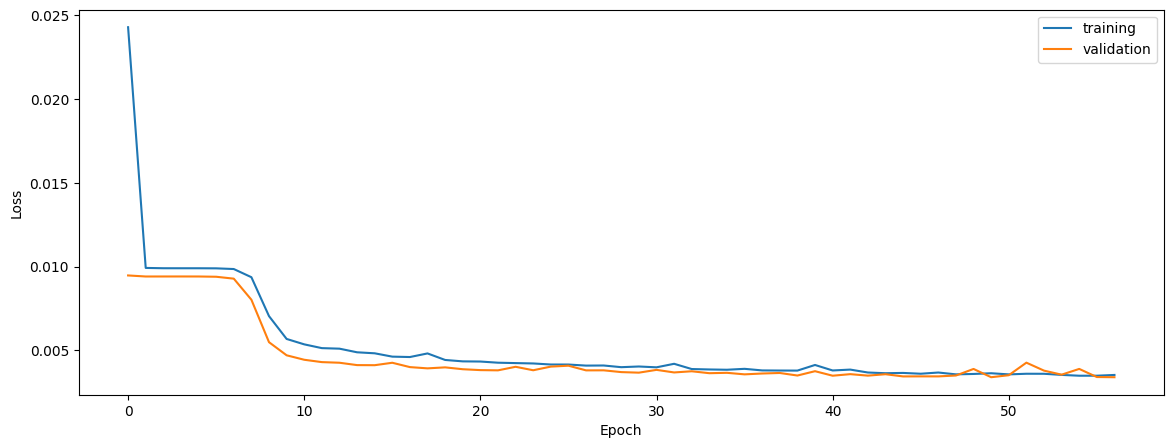

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8044761921666156
0.7993524979649688
0.7585157541291689


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.8044761921666156
0.7993524979649688
0.7585157541291689


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.8081781267606525
0.8017613000931859
0.7696458092879629


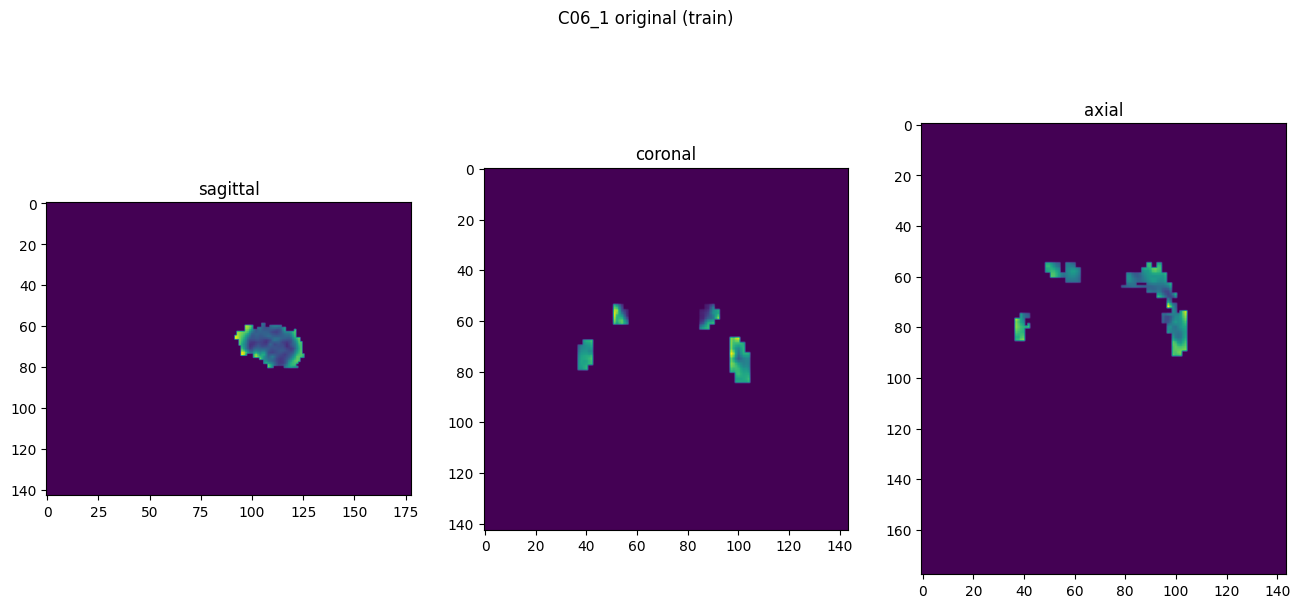

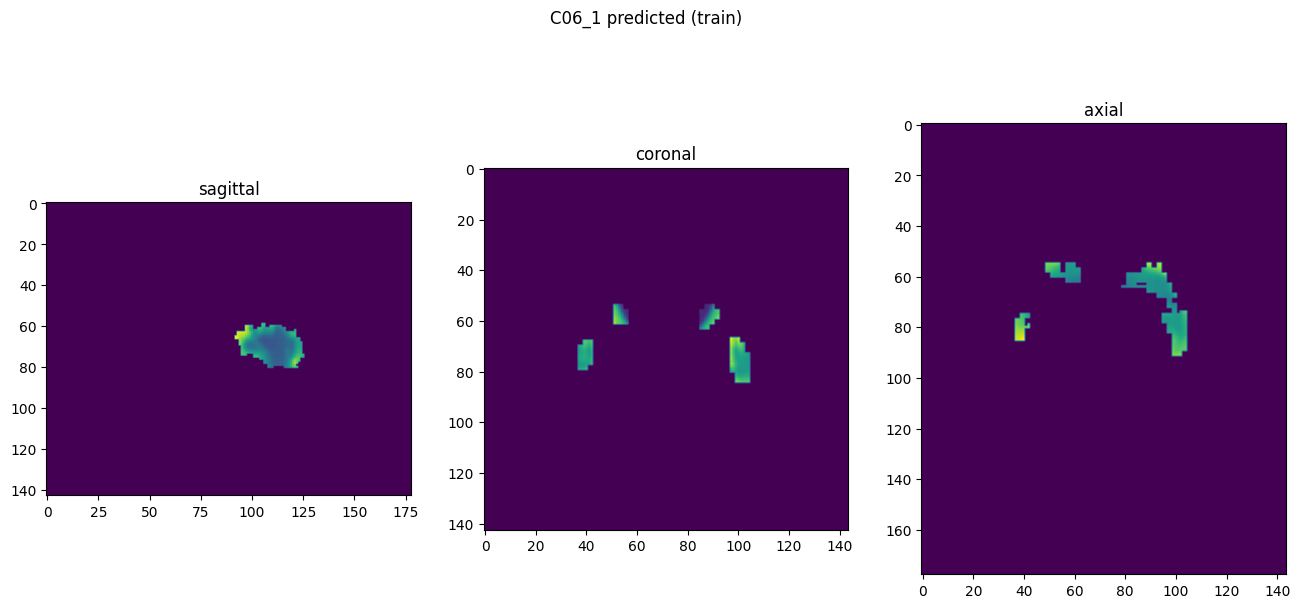

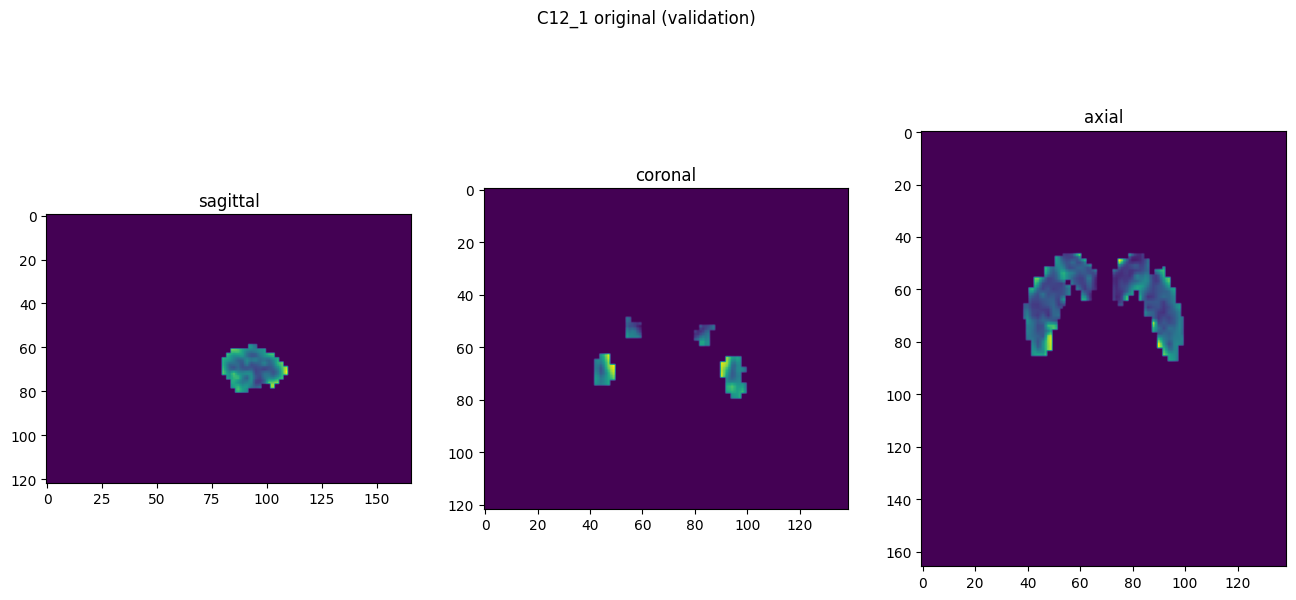

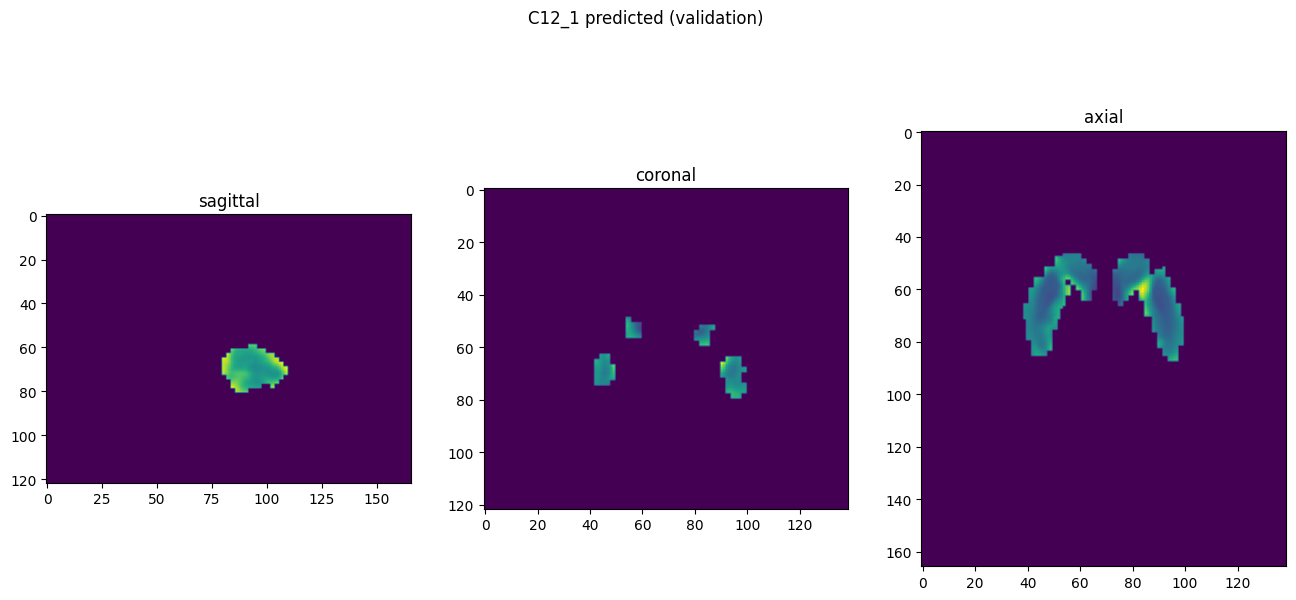

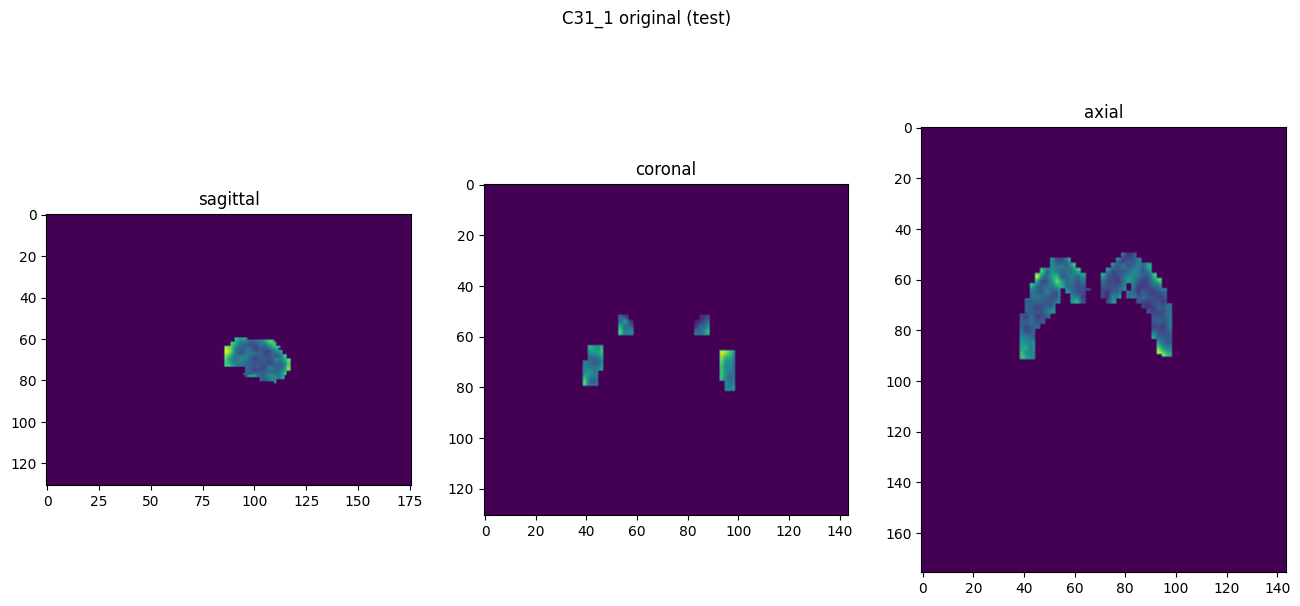

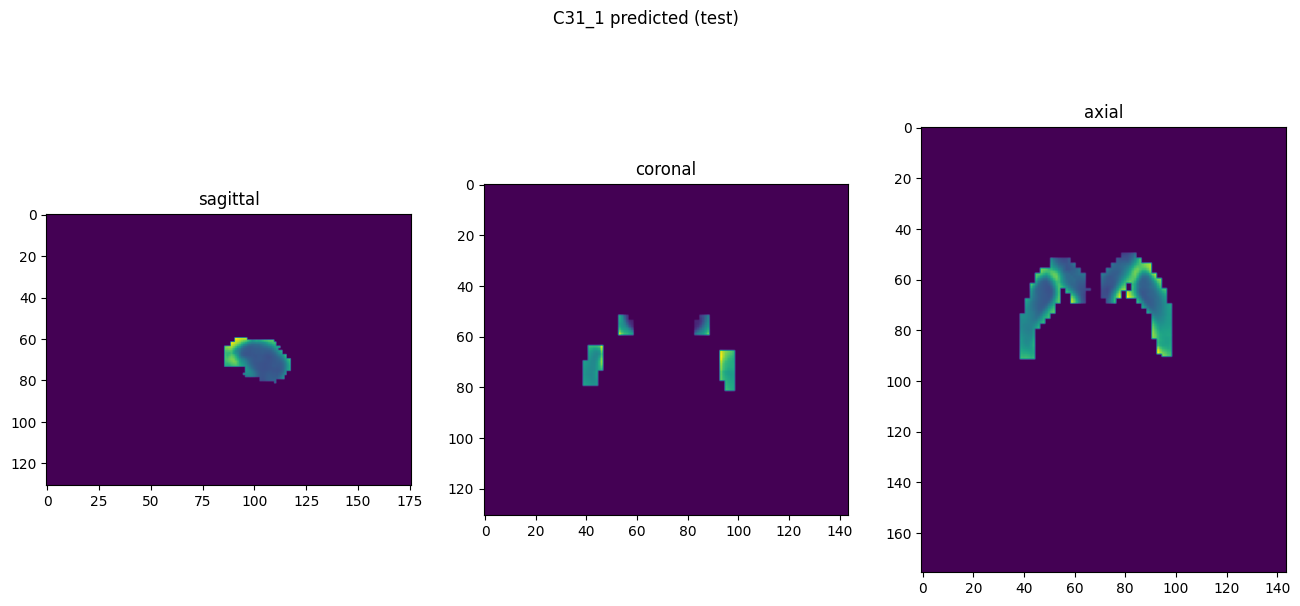

In [10]:
showResults(model, gen, threshold=None, background=False)